#  Diffusion Models


In this notebook we implement a Denoising Diffusion Probabilistic Model (DDPM).
For references please refer to the original [DDPM paper](https://arxiv.org/pdf/2006.11239.pdf).
.



# Denoising Diffusion Probabilistic Models (DDPMs) 

## Introduction

Denoising Diffusion Probabilistic Models (DDPM) are deep generative models that are recently getting a lot of attention due to their impressive performances. Brand new models like OpenAI’s DALL-E 2 and Google’s Imagen generators are based on DDPMs.

The idea is quite simple: given a dataset of images, we add a little bit of noise step-by-step. With each step, the image becomes less and less clear, until all that is left is noise. This is called the “forward process”. Then, we learn a machine learning model that can undo each of such steps, and we call it the “backward process”. If we can successfully learn a backward process, we have a model that can generate images from pure random noise.

A step in the forward process consists in making the input image noisier (x at step t) by sampling from a multivariate gaussian distribution which mean is a scaled-down version of the previous image (x at step t-1) and which covariance matrix is diagonal and fixed. In other words, we perturb each pixel in the image independently by adding some normally distributed value:

![image](https://learnopencv.com/wp-content/uploads/2023/01/diffusion-models-forwardbackward_process_ddpm.png "The main idea of DDPM: Map images x0 to more and more noisy images with probability distribution q. Then, learn the inverse function p parametrized by parameters theta. The image is taken from “Denoising DIffusion Probabilistic Models” by Ho et. al.")

For the backward process, we know our model should also work as a gaussian distribution, so we would just need the model to predict the distribution mean and standard deviation given the noisy image and time step. In practice, in this first paper on DDPMs the covariance matrix is kept fixed, so we only really want to predict the mean of the gaussian (given the noisy image and the time step we are at currently):

![image](https://learnopencv.com/wp-content/uploads/2023/02/denoising-diffusion-probabilistic-models-overall_forward_diffusion_process-1.png)

We will delve deeper into the details of the forward (diffusion) and backward (denoising) processes in the relevant cells.

In this homework, we aim to implement a DDPM from scratch to generate random captcha images from noise. Our goal is to make our DDPM conditional on the captcha text to generate images for specific input texts.

## Packages

As usual, imports are trivially our first step.



In [ ]:
import os
import random
import string
import math
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms
from torchvision.datasets import VisionDataset
# from transformers import AutoTokenizer, AutoModel

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Dataset 
We'll focus on the small captcha dataset comprising around 1070 images, each labeled with a 5-character text (lowercase letters and digits). The dataset represents a tiny fraction of the total possible captchas, estimated at 5^36. Our aim is to generate new captchas not present in the provided dataset. Each sample is a 50x200 RGB image paired with a text label. To begin, download our data and create a custom vision dataset by running the following two cells:

In [ ]:
%%capture
!pip install gdown
!gdown 1P_EQv94d03y59kFPQ2gZLOLMAJs6cLVI
!unzip captcha_v2.zip

In [ ]:
class Captcha(VisionDataset):
    def __init__(self, root, transform=None, target_transform=None):
        # Initializing Captcha Dataset class
        super(Captcha, self).__init__(root, transform=transform, target_transform=target_transform)
        # Listing all files in the provided root directory
        self.files = sorted(os.listdir(root))

        # Initializing lists to store images and their respective labels
        self.images = []
        self.labels = []

        # Iterating through each file in the root directory
        for img in self.files:
            # Checking if the file is an image file
            if self.is_image_file(img):
                # Extracting label from filename (before the extension)
                name = os.path.basename(img)
                label = name.split('.')[0]
                # Storing image path and label
                self.images.append(os.path.join(self.root, img))
                self.labels.append(label)

    def __len__(self):
        # Returning the total number of images
        return len(self.labels)

    def __getitem__(self, idx:int):
        # Retrieving image and target label based on index
        img, target = self.images[idx], self.labels[idx]

        # Checking if the index is a slice (multiple items requested)
        if isinstance(idx, slice):
            tmp = []
            # Iterating through each image in the slice
            for item in img:
                # Applying transformations if specified
                if self.transform is not None:
                    tmp.append(self.transform(self.read_image(item)))
                else:
                    tmp.append(self.read_image(item))
            img = tmp
        else:
            # Applying transformations if specified
            if self.transform is not None:
                img = self.transform(self.read_image(img))
            else:
                img = self.read_image(img)

        # Applying target transformations if specified
        if self.target_transform is not None:
            if isinstance(idx, slice):
                tmp = []
                # Iterating through each target label in the slice
                for t in target:
                    tmp.append(self.target_transform(t))
                target = tmp
            else:
                target = self.target_transform(target)

        # Returning image and target label
        return img, target

    # Method to read image from file path
    def read_image(self, path):
        img = Image.open(path)
        # Converting image to RGB format
        return img.convert('RGB')

    # Method to check if a file is an image file
    def is_image_file(self, filename):
        # Checking if filename ends with any of the specified image extensions
        return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])


The images we read are in PIL format via the Pillow library. Initially, we apply below transforms to the raw images:
* rezie  to a final size of `64 by 256`
* converting  into a tensor
* and normalizing values to a `mean` and `standard deviation` of 0.5.

In [ ]:

transform = transforms.Compose(
    [
        # Example:
        # transforms.Pad((1, 1), padding_mode='edge')
        # transforms.CenterCrop(config.image_size),
        transforms.Resize((64, 256)),
        # transforms.RandomHorizontalFlip(),
        # transforms.Pad((28, 7), padding_mode='edge'),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


target_transform = None


In [ ]:
# Defining the path where the dataset is stored
DATA_PATH = './captcha_v2/'


##########################################################

dataset = Captcha(DATA_PATH, transform=transform)



In the next step, we utilize the `dataloader` for model training and `plot_samples` to visualize sequences of images, such as iteratively denoised images by DDPM.

In [ ]:


# Define your desired batch size for training or evaluation
BATCH_SIZE = 16

# Create a Dataloader instance for loading data in batches
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)



In [ ]:
# Define function to plot images
def plot_images(images):
    plt.figure(figsize=(16, 3))

    plt.imshow(torch.cat([i for i in images], dim=-1).permute(1, 2, 0).cpu() / 2 + 0.5)

    plt.axis('off')

    plt.show()


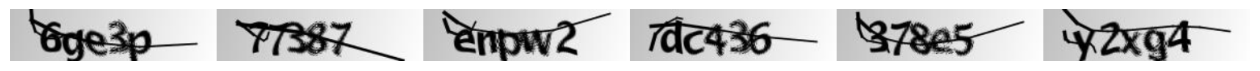

In [ ]:
# gettng some random samples from our dataset
# Define the number of samples to display
num_samples = 6
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:num_samples])

## DDPM Architecture

The overall procedure of training and sampling from DDPM is represented in the following pseudocodes from DDPM paper. For more details on the loss function and the sampling process, please refer to the course slides and the paper.
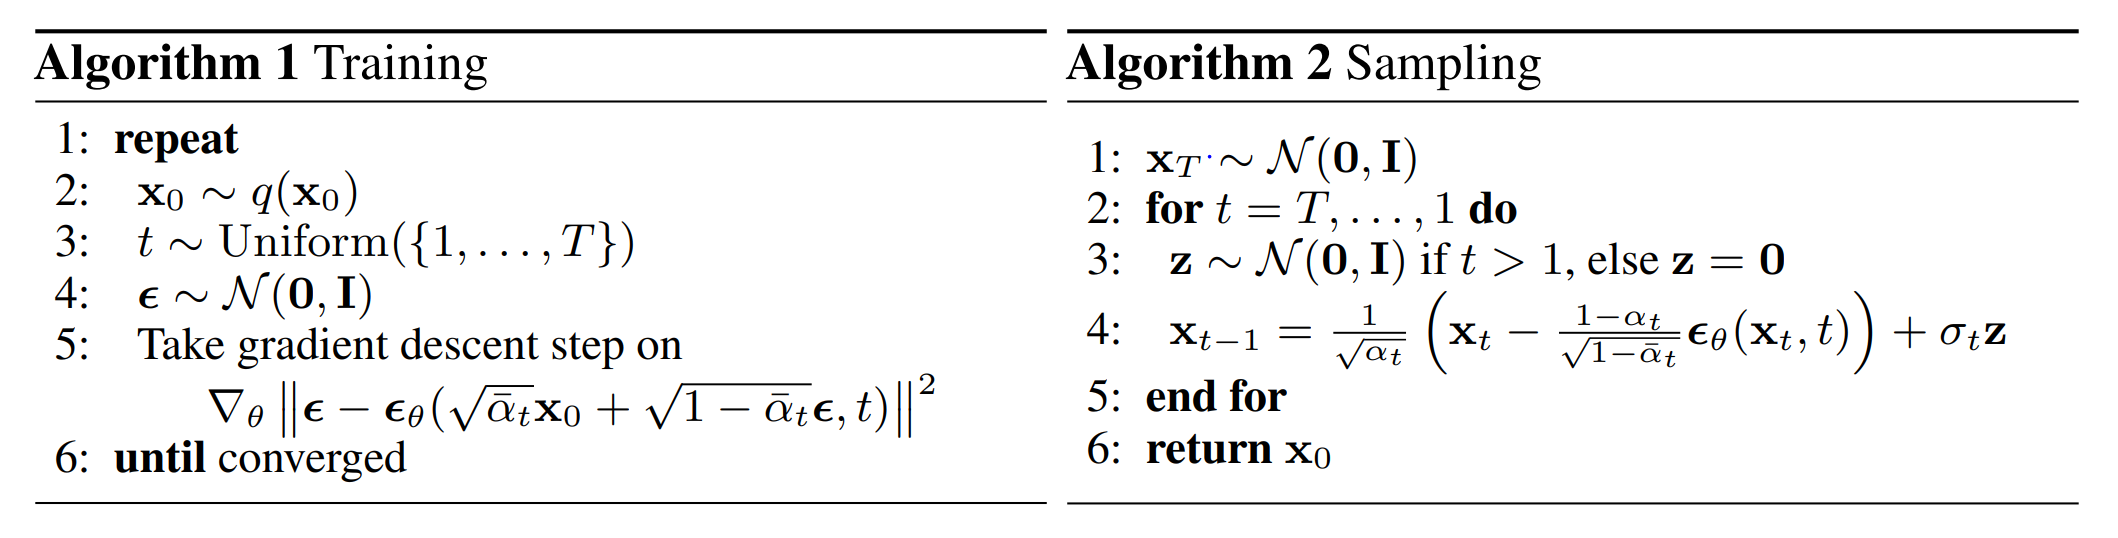

According to the given pseudocode, In the reverse diffusion process, the task is to learn a finite-time (within T timesteps) reversal of the forward diffusion process. So we only need to train a model that learns to reverse the noise from an input image at a specific time step. In this notebook, we will use the fully convolutional network architecture proposed by the paper, a U-Net with image and time as the inputs and predicted noise as the output. They augment the regular UNet with several sub-modules and techniques such as ResNets, Attention modules and etc. We describe The UNet network and its architecture in the next section.

The pseudocode also shows that the loss function is defined as an MSE on per time step noise and the predicted noise for the current time step. Therefore, we will also use the mentioned loss function to train the network. The pseudo-code provides the formula for generating both noisy and less noisy images, that will be used in the relevant section.


### U-Net

The U-Net architecture, a convolutional neural network framework, has emerged as a powerful tool for semantic segmentation tasks, U-Net is characterized by its unique U-shaped architecture, that allows U-Net to efficiently learn both global and local features, enabling it to achieve best performance in various segmentation challenges.
![unet_ong](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png)

It consists of a contracting path and an expansive path. The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU.

The figure above illustrates the 2015 U-Net architecture. However, for this homework, we require a customized version with additional sub-modules. In the following cells, we will outline the necessary modules and complete their implementation to construct our final network.

#### Resnet Block

As a base sub-module, we define each Resnet block as two consecutive convolutional layers with a Group Normalization and SiLU activation `before` each convolutional layer. This block will be used other sub-modules (eg:Down/Up blocks):
* GroupNorm
* SiLU
* Conv
* GroupNorm
* SiLU
* Conv

Additionally, there's a linear projection layer that converts the time embedding vector to a vector matching the number of output channels. This projected time embedding is then added to the input after the first convolutional layer. Also, by removing the residual connection, you can use this block as a convolutional network.

Note that if the number of input and output channels for feature maps differs, adding the input to the output for a residual connection may cause issues. In such cases, a 1x1 convolution can be used to ensure input channels match the output dimensions.

Optionally, a dropout layer can added before the second convolution layer. By default, its probability is set to zero, but you can activate it if necessary in your final architecture.

In [ ]:
class ResnetBlock(nn.Module):

    def __init__(self, in_ch, out_ch, temb_size, dropout=0, norm_groups=1, residual=True, **kwargs):
        super(ResnetBlock, self).__init__()
        kernel_size = 3
        padding = 'same'
        bias = True
        self.residual = residual

        # 
        self.stack1 = nn.Sequential(
            nn.GroupNorm(num_groups=norm_groups, num_channels=in_ch),
            nn.SiLU(),
            nn.Conv2d(in_ch, out_ch, kernel_size, padding=padding, bias=bias),
        )

        self.time_projction = nn.Linear(temb_size, out_ch)
        # if cemb_size:
        #     self.class_projection = nn.Linear(cemb_size, out_ch)
        self.stack2 = nn.Sequential(
            nn.GroupNorm(num_groups=norm_groups, num_channels=out_ch),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, kernel_size, padding=padding, bias=bias),
        )

        self.use_skip_shortcut = in_ch != out_ch

        self.skip_shortcut = None
        if self.use_skip_shortcut:
            self.skip_shortcut = nn.Conv2d(
                in_ch,
                out_ch,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=True,
            )

    def forward(self, x, t):

        #
        z = self.stack1(x)
        t = self.time_projction(t)[:,:, None, None]
        z = self.stack2(z + t)
        if self.use_skip_shortcut:
            x = self.skip_shortcut(x)
        return z + x if self.residual else z


In [ ]:
# test out block
test_module = ResnetBlock(128, 256, 32)
temb = torch.randn(1, 32)
sample = torch.randn(1, 128, 64, 64)
output = test_module(sample, temb)
assert sample.shape[2:] == output.shape[2:]
assert output.shape[1] == 256
output.shape

torch.Size([1, 256, 64, 64])

#### Attention Block
This sub-module consisting of :
 * a Group Normalization
 * Multi-head Attention (you can use `torch.nn`)
 * residual conntection
 * a feed-forward layer
 * and another residual connection.




In [ ]:
class AttentionBlock(nn.Module):

    def __init__(self, feature_dim, num_heads=4, norm_groups=1, dropout=0, **kwargs):

        super(AttentionBlock, self).__init__()

        # 
        self.feature_dim = feature_dim
        # self.norm = nn.LayerNorm([feature_dim])
        self.norm = nn.GroupNorm(num_groups=norm_groups, num_channels=feature_dim)
        self.attention = nn.MultiheadAttention(embed_dim=feature_dim, num_heads=num_heads, batch_first=True)
        self.stack = nn.Sequential(
            nn.Linear(feature_dim, feature_dim),
            nn.Dropout(dropout),
        )



    def forward(self, x):

        B, C, H, W = x.shape

        x_norm = self.norm(x.view(-1, self.feature_dim, H*W)).transpose(1, 2)
        atten, _ = self.attention(x_norm, x_norm, x_norm, need_weights=False)
        atten = atten + x.view(-1, self.feature_dim, H*W).transpose(1, 2)
        z = self.stack(atten)
        z = z.transpose(1, 2).view(-1, self.feature_dim, H, W) + x

        return z



#### Down Block

This block is a downsampling block comprised of a series of ResnetBlocks, followed by a downsampling module. The number of **ResnetBlocks** is determined by `num_layers`, also input channels for the first ResnetBlock is `in_ch`, and the output channels for last one is `out_ch`, which should be considered in your implementation.

The downsampling module halves the width and height of the input and can be implemented using either a convolution layer with `stride=2` or an average pooling layer with `kernel_size=2`, depending on your architecture.




In [ ]:
class DownBlock(nn.Module):

    def __init__(self, in_ch, out_ch, temb_size, dropout, norm_groups, num_layers=1, add_sampling=True, **kwargs):
        super(DownBlock, self).__init__()

        # Create a list to store ResnetBlocks
        blocks = []

        # Loop to create specified number of ResnetBlocks
        for i in range(num_layers):
            blocks.append(
                ResnetBlock(
                    in_ch=in_ch,
                    out_ch=out_ch,
                    temb_size=temb_size,
                    dropout=dropout,
                    norm_groups=norm_groups,
                )
            )
            in_ch = out_ch  # Update in_ch for the next layer

        # Convert the list of ResnetBlocks to a ModuleList
        self.res_blocks = nn.ModuleList(blocks)

        # Initialize downsampling layer if add_sampling is True
        self.sampler = None
        if add_sampling:
            self.sampler = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=2, padding=1, bias=True)
            # Alternative downsampling method: self.sampler = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x, t):


        hidden_states = ()
        for block in self.res_blocks:
            x = block(x, t)
            hidden_states = hidden_states + (x,)
        # Apply downsampling if sampler is defined
        if self.sampler:
            x = self.sampler(x)
            hidden_states = hidden_states + (x,)
        return x, hidden_states



In [ ]:
# test your block
test_module1 = DownBlock(128, 256, 128, 0 , 32,)
test_module2 = DownBlock(128, 256, 128, 0 , 32, 3, add_sampling=False)
temb = torch.randn(1, 128)
sample = torch.randn(1, 128, 64, 64)
output1, hidden1 = test_module1(sample, temb)
output2, hidden2 = test_module2(sample, temb)
assert sample.shape[2] == output1.shape[2] * 2
assert sample.shape[2] == output2.shape[2]
assert output1.shape[1] == 256
assert output2.shape[1] == 256
assert len(hidden1) == 2
assert len(hidden2) == 3
print('successful.')

successful.


#### AttentionDown Block

This block is similar to the DownBlock but with two differences:

1. There's an Attention Block after each ResnetBlock, resulting in `num_layers` ResnetBlocks and `num_layers` AttentionBlocks.
2. The downsampling module is always present.

Note that you can choose between two types of downsampling modules, similar to the DownBlock.

In [ ]:
class AttntionDownBlock(nn.Module):

    def __init__(self, in_ch, out_ch, temb_size, dropout, norm_groups, num_layers=1, num_heads=8, **kwargs):
        super(AttntionDownBlock, self).__init__()

        atten_blocks = []
        res_blocks = []

        # Loop to create specified number of ResnetBlocks and AttentionBlocks
        for i in range(num_layers):
            res_blocks.append(
                ResnetBlock(
                    in_ch=in_ch,
                    out_ch=out_ch,
                    temb_size=temb_size,
                    dropout=dropout,
                    norm_groups=norm_groups,
                )
            )
            atten_blocks.append(
                AttentionBlock(
                    feature_dim=out_ch,
                    num_heads=num_heads,
                    norm_groups=norm_groups,
                    dropout=dropout,
                )
            )
            in_ch = out_ch  # Update in_ch for the next layer

        # Convert the lists of ResnetBlocks and AttentionBlocks to ModuleLists
        self.atten_blocks = nn.ModuleList(atten_blocks)
        self.res_blocks = nn.ModuleList(res_blocks)

        # Initialize downsampling layer
        self.sampler = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=2, padding=1, bias=True)


    def forward(self, x, t):

        hidden_states = ()
        # Iterate through ResnetBlocks and AttentionBlocks
        for res, att in zip(self.res_blocks, self.atten_blocks):
            x = res(x, t)
            x = att(x)
            hidden_states = hidden_states + (x,)
        # Apply downsampling
        x = self.sampler(x)
        hidden_states = hidden_states + (x,)
        return x, hidden_states


In [ ]:
# test your block
test_module = AttntionDownBlock(128, 256, 128, 0 , 32,3)
temb = torch.randn(1, 128)
sample = torch.randn(1, 128, 64, 64)
output, hidden = test_module(sample, temb)
assert sample.shape[2] == output1.shape[2] * 2
assert output.shape[1] == 256
assert len(hidden) == 4
print('successful.')

successful.


#### Up Block
This block is utilized in the expansive path of the U-Net. Its architecture resembles the DownBlocks, consisting of `num_layers` consecutive ResnetBlocks. Following the ResnetBlocks, there's an upsample module with two possible options based on the network architecture:

* An upsample layer followed by a convolution layer.
* A convolution transpose layer with appropriate parameters.

The UpBlock also includes an extra parameter, `skip_ch`, indicating the number of channels in the skip connection from the contractive path. Note that these skip channels affect the number of input channels of the ResnetBlocks, which should be considered in your implementation.

In the forward method, in addition to the input tensor and time embedding tensor, it takes the hidden states from the contractive path of the U-Net as the third input. Each hidden state is concatenated with the input before processing it through a ResnetBlock.


In [ ]:
class UpBlock(nn.Module):

    def __init__(self, in_ch, skip_ch, out_ch, temb_size, dropout, norm_groups, num_layers=1, add_sampling=True, **kwargs):
        super(UpBlock, self).__init__()

        blocks = []

        # Loop to create specified number of ResnetBlocks
        for i in range(num_layers):
            # Determine input channels for ResnetBlock based on layer index
            res_skip_channels = skip_ch if (i == num_layers - 1) else out_ch
            resnet_in_channels =  in_ch if i == 0 else out_ch

            blocks.append(
                ResnetBlock(
                    in_ch=resnet_in_channels + res_skip_channels,
                    out_ch=out_ch,
                    temb_size=temb_size,
                    norm_groups=norm_groups,
                    dropout=dropout,
                )
            )

        # Convert the list of ResnetBlocks to a ModuleList
        self.res_blocks = nn.ModuleList(blocks)

        # Initialize upsampling layer if add_sampling is True
        self.sampler = None
        if add_sampling:
            self.sampler = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=True)
            )
            # Alternative upsampling method: self.sampler = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=4, stride=2, padding=padding, bias=True)

    def forward(self, x, t, hidden_states):

        for block in self.res_blocks:
            hs = hidden_states[-1]  # Get the last hidden state
            hidden_states = hidden_states[:-1]  # Remove the last hidden state from the tuple
            x = torch.cat([x, hs], dim=1)  # Concatenate the input tensor with the hidden state
            x = block(x, t)  # Pass through the ResnetBlock
        # Apply upsampling if sampler is defined
        if self.sampler:
            x = self.sampler(x)
        return x


In [ ]:
# test your block
test_module = UpBlock(256 ,128, 256, 128, 0 , 32,3)
temb = torch.randn(1, 128)
sample = torch.randn(1, 256, 64, 64)
hidden_states = (torch.randn(1, 128, 64, 64), torch.randn(1, 256, 64, 64), torch.randn(1, 256, 64, 64))
output = test_module(sample, temb, hidden_states)
assert sample.shape[2] * 2  == output.shape[2]
assert output.shape[1] == 256
print('successful.')

successful.


In [ ]:
output.shape

torch.Size([1, 256, 128, 128])

#### AttentionUp Block
This block shares the same architecture as the UpBlock, with an additional attention block after each ResnetBlock. Furthermore, it includes an upsample module, similar to the UpBlock, following the Resnet and attention blocks.

In [ ]:
class AttentionUpBlock(nn.Module):

    def __init__(self, in_ch, skip_ch, out_ch, temb_size, dropout, norm_groups, num_layers=1, num_heads=8, **kwargs):
        super(AttentionUpBlock, self).__init__()

        res_blocks = []
        atten_blocks = []

        # Loop to create specified number of ResnetBlocks and AttentionBlocks
        for i in range(num_layers):
            # Determine input channels for ResnetBlock based on layer index
            res_skip_channels = skip_ch if (i == num_layers - 1) else out_ch
            resnet_in_channels = in_ch if i == 0 else out_ch

            res_blocks.append(
                ResnetBlock(
                    in_ch=resnet_in_channels + res_skip_channels,
                    out_ch=out_ch,
                    temb_size=temb_size,
                    norm_groups=norm_groups,
                    dropout=dropout,
                )
            )
            atten_blocks.append(
                AttentionBlock(
                    feature_dim=out_ch,
                    num_heads=num_heads,
                    norm_groups=norm_groups,
                    dropout=dropout,
                )
            )

        # Convert the lists of ResnetBlocks and AttentionBlocks to ModuleLists
        self.res_blocks = nn.ModuleList(res_blocks)
        self.atten_blocks = nn.ModuleList(atten_blocks)

        # Initialize upsampling layer
        self.sampler = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=True)
        )

    def forward(self, x, t, hidden_states):

        for res, att in zip(self.res_blocks, self.atten_blocks):
            hs = hidden_states[-1]  # Get the last hidden state
            hidden_states = hidden_states[:-1]  # Remove the last hidden state from the tuple
            x = torch.cat([x, hs], dim=1)  # Concatenate the input tensor with the hidden state
            x = res(x, t)  # Pass through the ResnetBlock
            x = att(x)  # Pass through the AttentionBlock
        # Apply upsampling
        x = self.sampler(x)
        return x


#### Mid Block
In the U-Net architecture, there are bottleneck layers between the contractive and expansive paths. These can be implemented using ResnetBlocks with or without attention layers. Specifically, we define the MidBlock with `num_layers` of ResnetBlocks having the same number of input and output channels, followed by an AttentionBlock.

In [ ]:
class MidBlock(nn.Module):

    def __init__(self, in_ch, temb_size, dropout, norm_groups, num_layers=1, num_heads=8, **kwargs):
        super(MidBlock, self).__init__()
        # Create a list to store ResnetBlocks
        blocks = []

        # Loop to create specified number of ResnetBlocks
        for i in range(num_layers):
            blocks.append(
                ResnetBlock(
                    in_ch=in_ch,
                    out_ch=in_ch,
                    temb_size=temb_size,
                    dropout=dropout,
                    norm_groups=norm_groups,
                )
            )

        # Convert the list of ResnetBlocks to a ModuleList
        self.res_blocks = nn.ModuleList(blocks)
        self.attention = AttentionBlock(
                    feature_dim=in_ch,
                    num_heads=num_heads,
                    norm_groups=norm_groups,
                    dropout=dropout,
                )

    def forward(self, x, t):

        for res in self.res_blocks:
            x = res(x, t)
        x = self.attention(x)
        return x


#### Positional Encoding
In previous sections, we discussed how U-Net predicts noise at each time step. To incorporate the time step into the network, we encode it into an embedding vector and pass it to various layers. Various position encoding methods exist, but we use Sinusoidal position embeddings proposed in the ["Attention is All You Need."](https://arxiv.org/pdf/1706.03762.pdf) paper for this purpose. For more technical details, please refer to the paper.

In [ ]:
class SinusoidalPosition(nn.Module):


    def __init__(self, embedding_dim, max_period=10000):
        super(SinusoidalPosition, self).__init__()
        self.max_period = max_period
        self.embedding_dim = embedding_dim


    def forward(self, timesteps: torch.Tensor):

        assert len(timesteps.shape) == 1, "Timesteps should be a 1d-array"

        # Calculate half_dim for sine and cosine embeddings
        half_dim = self.embedding_dim // 2

        # Calculate exponents for sine and cosine embeddings
        exponent = -math.log(self.max_period) * torch.arange(start=0, end=half_dim, dtype=torch.float32, device=timesteps.device)
        exponent = exponent / (half_dim - 1)

        # Calculate sine and cosine embeddings
        emb = torch.exp(exponent)
        emb = timesteps[:, None].float() * emb[None, :]

        # Concatenate sine and cosine embeddings
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

        # Zero pad if necessary
        if self.embedding_dim % 2 == 1:
            emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))

        return emb


#### Final Network
In this section, we'll construct our U-Net architecture using the blocks defined above. The architecture of the network varies depending on the problem we want to solve. However, for simplicity, we propose a basic architecture suitable for our captcha generation problrm.
Proposed Contractive Path Architecture:
- Convolution layer (in_ch > 128)
- DownBlock (128 > 128), num_layers=2
- DownBlock (128 > 128), num_layers=2
- DownBlock (128 > 256), num_layers=2
- AttentionDownBlock (256 > 256), num_layers=2
- AttentionDownBlock (256 > 512), num_layers=2
- DownBlock (512 > 512, without sampling)

Proposed Bottleneck Architecture:
- MidBlock

Proposed Expansive Path Architecture (calculate input and skip channels depending on the contractive path):
- UpBlock
- AttentionUpBlock
- AttentionUpBlock
- UpBlock
- UpBlock
- UpBlock (without sampling)
- (Optional) Group norm + SiLU
- Convolution layer



In [ ]:
class UNet(nn.Module):

    def __init__(self, in_ch, out_ch, temb_size, norm_groups, dropout=0, num_layers=2, num_heads=8, **kwargs):
        super(UNet, self).__init__()

        # Initialize parameters
        self.temb_size = temb_size
        self.norm_groups = norm_groups
        self.num_res_layers = num_layers
        self.dropout = dropout
        self.num_attention_heads = num_heads
        self.pos_embedding_dim = 128

        block_out_channels=(128, 128, 256, 256, 512, 512)

        self.pos_encoding = SinusoidalPosition(self.pos_embedding_dim)
        self.time_proj = nn.Sequential(
            nn.Linear(self.pos_embedding_dim, self.temb_size),
            nn.SiLU(),
            nn.Linear(self.temb_size, self.temb_size)
        )

        self.conv_in = nn.Conv2d(in_ch, block_out_channels[0], kernel_size=3, padding=(1, 1))
        self.down = nn.ModuleList([])
        # down blocks
        self.down.append(DownBlock(
            in_ch=block_out_channels[0],
            out_ch=block_out_channels[0],
            temb_size=self.temb_size,
            dropout=self.dropout ,
            norm_groups=self.norm_groups,
            num_layers=self.num_res_layers,
        ))
        self.down.append(DownBlock(
            in_ch=block_out_channels[0],
            out_ch=block_out_channels[1],
            temb_size=self.temb_size,
            dropout=self.dropout ,
            norm_groups=self.norm_groups,
            num_layers=self.num_res_layers,
        ))
        self.down.append(DownBlock(
            in_ch=block_out_channels[1],
            out_ch=block_out_channels[2],
            temb_size=self.temb_size,
            dropout=self.dropout,
            norm_groups=self.norm_groups,
            num_layers=self.num_res_layers,
        ))
        self.down.append(AttntionDownBlock(
            in_ch=block_out_channels[2],
            out_ch=block_out_channels[3],
            temb_size=self.temb_size,
            dropout=self.dropout,
            norm_groups=self.norm_groups,
            num_layers=self.num_res_layers,
        ))
        self.down.append(AttntionDownBlock(
            in_ch=block_out_channels[3],
            out_ch=block_out_channels[4],
            temb_size=self.temb_size,
            dropout=self.dropout,
            norm_groups=self.norm_groups,
            num_layers=self.num_res_layers,
            num_heads=self.num_attention_heads,
        ))
        self.down.append(DownBlock(
            in_ch=block_out_channels[4],
            out_ch=block_out_channels[5],
            temb_size=self.temb_size,
            dropout=self.dropout,
            norm_groups=self.norm_groups,
            num_layers=self.num_res_layers,
            add_sampling=False,
        ))
        # mid blocks
        self.mid = MidBlock(
            in_ch=block_out_channels[-1],
            temb_size=self.temb_size,
            dropout=self.dropout,
            norm_groups=self.norm_groups,
            num_heads=self.num_attention_heads,
        )

        # up blocks
        self.up = nn.ModuleList([])

        self.up.append(UpBlock(
            in_ch=512,
            skip_ch=512,
            out_ch=512,
            temb_size=self.temb_size,
            dropout=self.dropout,
            norm_groups=self.norm_groups,
            num_layers=self.num_res_layers+1,

        ))
        self.up.append(AttentionUpBlock(
            in_ch=512,
            skip_ch=256,
            out_ch=512,
            temb_size=self.temb_size,
            dropout=self.dropout,
            norm_groups=self.norm_groups,
            num_layers=self.num_res_layers+1,
            num_heads=self.num_attention_heads,

        ))
        self.up.append(AttentionUpBlock(
            in_ch=512,
            skip_ch=256,
            out_ch=256,
            temb_size=self.temb_size,
            dropout=self.dropout,
            norm_groups=self.norm_groups,
            num_layers=self.num_res_layers+1,

        ))
        self.up.append(UpBlock(
            in_ch=256,
            skip_ch=128,
            out_ch=256,
            temb_size=self.temb_size,
            dropout=self.dropout,
            norm_groups=self.norm_groups,
            num_layers=self.num_res_layers+1,

        ))
        self.up.append(UpBlock(
            in_ch=256,
            skip_ch=128,
            out_ch=128,
            temb_size=self.temb_size,
            dropout=self.dropout,
            norm_groups=self.norm_groups,
            num_layers=self.num_res_layers+1,
            # add_sampling=False,
        ))
        self.up.append(UpBlock(
            in_ch=128,
            skip_ch=128,
            out_ch=128,
            temb_size=self.temb_size,
            dropout=self.dropout,
            norm_groups=self.norm_groups,
            num_layers=self.num_res_layers+1,
            add_sampling=False,

        ))
        self.to_out = nn.Sequential(
            nn.GroupNorm(num_channels=block_out_channels[0], num_groups=self.norm_groups),
            nn.SiLU(),
            nn.Conv2d(block_out_channels[0], out_ch, kernel_size=3, padding=1),
        )



    def forward(self, x, t):

        # Perform positional encoding
        t = self.pos_encoding(t)
        temb = self.time_proj(t)
        temb = temb

        # Apply convolutional input layer
        x = self.conv_in(x)
        hidden_states = (x, )

        # Apply downsampling blocks
        for d in self.down:
            x, hs = d(x, temb)
            hidden_states += hs

        # Apply mid block
        x = self.mid(x, temb)

        # Apply upsampling blocks
        for i, u in enumerate(self.up):
            res_samples = hidden_states[-len(u.res_blocks) :]
            hidden_states = hidden_states[: -len(u.res_blocks)]
            x = u(x, temb, res_samples)

        # Apply output layer
        x = self.to_out(x)

        return x


In [ ]:
# test unet
test_unet = UNet(1, 1, 32, 8)
time_steps = torch.tensor([1])
sample = torch.randn(1, 1, 64, 64)
output = test_unet(sample, time_steps)
assert sample.shape == output.shape
output.shape

torch.Size([1, 1, 64, 64])

## Noise Schuduling
Recall that the in diffusion forward process given a data point sampled from a data distribution $ x_0 \sim q(x) $, we want to get a noisy image at step $T$. In particular, the forward diffusion process adds a small amount of Gaussian noise to the sample in $ T $ steps and produces a sequence of noisy samples $ x_1, \ldots, x_T $. The forward diffusion process is controlled by a variance schedule $ \{\beta_t \in (0.0001, 0.02)\}^T_{t=1} $.

$$ q(x_t|x_{t-1}) = N(x_t; \sqrt{1 - \beta_t}x_{t-1}, \beta_t\mathbf{I}) $$

$$ q(x_{1:T}|x_0) = \prod_{t=1}^T q(x_t|x_{t-1}) $$

The sampled image $ x_0 $ gradually becomes noisier as the step $ t $ becomes larger. Eventually when $ T \rightarrow \infty $, $ x_T $ is equivalent to an isotropic Gaussian distribution. This is a markov process and we can apply the above formulation $T$ times to get to a noisy image at timestep $T$. However, this process is slow and expensive. Fortunately this is not necessary!


Recall that we can sample $x_t$ at any timestep $t$ **directly** using the reparametarization trick.  
Let $\alpha_t = 1-\beta_t$ and $\hat{\alpha}_t = \prod_{i=1}^t \alpha_i$.  
Then  
$ q(x_t|x_0) = N(x_t; \sqrt{\hat{\alpha}_t}x_0, (1 - \hat{\alpha}_t)\mathbf{I})$  

Also in backward process we  can use below algorithm for sampling after training the diffusion model:

1. $ x_T \sim N(0, I) $
2. for $ t = T, \ldots, 1 $ do
3. &emsp;&emsp;$ z \sim N(0, I) $ if $ t > 1 $, else $ z = 0 $
4. &emsp;&emsp;$ x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_{\theta}(x_t, t) \right) + \sigma_t z $
5. end for
6. return $ x_0 $

We will implement the forward and sampling algorithms in the NoiseScheduler class.

In [ ]:
class NoiseScheduler:

    def __init__(
        self,
        num_train_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
    ):
        self.T = num_train_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end



        # Create beta and alpha values
        self.betas = torch.linspace(self.beta_start, self.beta_end, self.T)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)


    def add_noise(
        self,
        original_samples: torch.FloatTensor,
        noise: torch.FloatTensor,
        timesteps: torch.IntTensor,
    ) -> torch.FloatTensor:
       ############

        timesteps = timesteps.to(original_samples.device)
        alphas_cumprod = self.alphas_cumprod.to(original_samples.device)

        # Calculate alpha_bar for each timestep
        alpha_bar = alphas_cumprod[timesteps].view(-1, 1, 1, 1).to(original_samples.dtype)
        # Add noise based on alpha_bar
        noisy_samples =  alpha_bar.sqrt() * original_samples + torch.sqrt(1- alpha_bar) * noise
        return noisy_samples


    def denoise(
        self,
        noisy_sample: torch.FloatTensor,
        noise: torch.FloatTensor,
        timestep: int
    ) -> torch.FloatTensor:


        alpha = self.alphas[timestep].view(-1, 1, 1, 1).to(noisy_sample.device)
        beta = self.betas[timestep].view(-1, 1, 1, 1).to(noisy_sample.device)
        alpha_bar = self.alphas_cumprod[timestep].view(-1, 1, 1, 1).to(noisy_sample.device)

        # Generate noise z based on timestep
        if timestep > 1:
            z = torch.randn_like(noisy_sample, device=noisy_sample.device)
        else:
            z = torch.zeros_like(noisy_sample, device=noisy_sample.device)

        # Perform denoising operation
        x = 1 / alpha.sqrt() * (noisy_sample - (1 - alpha) / torch.sqrt(1 - alpha_bar) * noise) + beta.sqrt() * z
        return x



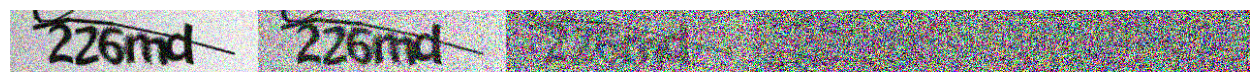

In [ ]:
# test our NoiseScheduler
test_scheduler = NoiseScheduler()
time_steps = torch.tensor([100, 200, 500, 700, 900])
sample = torch.cat([dataset[0][0].unsqueeze(0)] * time_steps.shape[0], dim=0)
noise = torch.randn_like(sample)
noisy_samples = test_scheduler.add_noise(sample, noise , time_steps)
plot_images(noisy_samples)

## Train and Sampling
We'll use the DDPM class to train our diffusion model and generate samples. Complete the train and sample methods according to the provided instructions.

In [ ]:
class DDPM:

    def __init__(self, sample_size , network, optimizer, criterion, noise_shdeduler: NoiseScheduler, device, lr_scheduler=None):
        self.sample_size = sample_size
        self.network = network.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = noise_shdeduler
        self.device = device
        self.lr_scheduler = lr_scheduler

    def train(self, dataloader, epochs, **kwargs):

        history = []
        for epoch in range(epochs):

            total_loss = []
            for i, batch in enumerate(tqdm(dataloader)):
                batch_x, batch_y = batch
                batch_x = batch_x.to(self.device)
                # batch_y = batch_y.to(self.device)

                # Sample a timestep t and create noisy images
                self.optimizer.zero_grad()
                self.network.train()

                timesteps = torch.randint(low=1, high=self.scheduler.T, size=(batch_x.size(0), ), device=self.device)
                epsilon = torch.randn_like(batch_x, device=self.device, dtype=batch_x.dtype)
                batch_x_noisy = self.scheduler.add_noise(batch_x, epsilon, timesteps)
                outputs = self.network(batch_x_noisy, timesteps)
                loss = self.criterion(outputs, epsilon)
                loss.backward()
                self.optimizer.step()
                if self.lr_scheduler:
                    self.lr_scheduler.step()
                total_loss.append(loss.item())


            mean_loss = np.mean(total_loss)
            lr_str = f"[lr: {self.lr_scheduler.get_last_lr()[0]}]" if self.lr_scheduler else ''
            print(f"[Epoch: {epoch+1}/{epochs}] [loss: {mean_loss:.4f}] {lr_str}")
            if (epoch+1) % 10 == 0:
                self.sample(5, plot=True)

            history.append(mean_loss)

        return history

    def sample(self, n, plot=True):

        with torch.no_grad():
            self.network.eval()
            C, H, W = self.sample_size
            x = torch.randn((1, C, H, W), device=self.device)
            xs = []
            step = self.scheduler.T // n
            for t in tqdm(torch.arange(self.scheduler.T - 1, -1 , -1, device=self.device)):
                noise = self.network(x, t.unsqueeze(0))
                x = self.scheduler.denoise(x, noise, t)
                if t % step == 0:
                    xs.append((x.squeeze(0).clamp(-1, 1)+1)/2)
            if plot:
                plot_images(xs)
            return x



To build and train our DDPM, first we must instantiate a UNet, noise scheduler, optimizer, and loss function. Then, create a DDPM object using them. To begin the training process, we should call the train method with our dataloader and the required number of epochs. It's recommended to use a learning rate scheduler with warmup steps (e.g., cosine schedule) to facilitate faster model convergence.

In [ ]:

IMG_SIZE = (3, 64, 256)
LR = 1e-4
EPOCHS = 50

In [ ]:
from transformers import get_cosine_schedule_with_warmup

In [ ]:

model = UNet(in_ch=3, out_ch=3, temb_size=512, norm_groups=32)
scheduler = NoiseScheduler()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = F.mse_loss
lr_scheduler = lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=300,
    num_training_steps=(len(dataloader) * EPOCHS),
)


In [ ]:
ddpm = DDPM(
    sample_size=IMG_SIZE,
    network=model,
    optimizer=optimizer,
    criterion=criterion,
    noise_shdeduler=scheduler,
    device=DEVICE,
    lr_scheduler=lr_scheduler
) # You can pass your arguments to the call.


In [ ]:
history = ddpm.train(dataloader, EPOCHS)

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 1/50] [loss: 0.6652] [lr: 2.2333333333333335e-05]


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 2/50] [loss: 0.1068] [lr: 4.466666666666667e-05]


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 3/50] [loss: 0.0606] [lr: 6.7e-05]


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 4/50] [loss: 0.0422] [lr: 8.933333333333334e-05]


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 5/50] [loss: 0.0314] [lr: 9.996751153992862e-05]


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 6/50] [loss: 0.0272] [lr: 9.972429737926605e-05]


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 7/50] [loss: 0.0242] [lr: 9.924435722181669e-05]


  0%|          | 0/67 [00:00<?, ?it/s]

Generate random samples from the trained model.

In [ ]:
s = ddpm.sample(5)

In [ ]:
s = ddpm.sample(5)

In [ ]:
s = ddpm.sample(5)

In [ ]:
# plot loss history
plt.plot(np.arange(EPOCHS), history)
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')